In [82]:
import os
import cv2
import base64
import requests
import json
import matplotlib.pyplot as plt
import shutil

CUTS_PATH = "/home/tyler/python/agents/cuts"
CUTS_DESCRIPTION_PATH = "/home/tyler/python/agents/cut_descriptions"
PERCENT_FRAMES_TO_SAMPLE = 0.4

In [88]:
def describe_image(buffer, model="llava:7b"):
    image_base64 = base64.b64encode(buffer).decode("utf-8")
    payload = {
        "model": model,
        "prompt": "Describe this image which is a frame from a video, include things like the position of objects in the screen and any text if it exists in the image. Only describe text if you're "
        "totally sure about what the text reads. Just describe the image and do not add any explaination or assumptions about what is happening.",
        "images": [image_base64],
    }
    response = requests.post("http://localhost:11434/api/generate", json=payload)

    full_response = ""
    for line in response.iter_lines():
        if line:
            # print(line.decode("utf-8"))
            data = json.loads(line)
            full_response += data.get("response", "")
    return full_response


def get_frames(cut_path):
    frame_buffers_to_return = []
    print(f"Cut name: {cut_path}")
    cap = cv2.VideoCapture(os.path.join(CUTS_PATH, cut_path))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frames:", total_frames)

    nth_frame_to_sample = int(1 / PERCENT_FRAMES_TO_SAMPLE)

    for frame_num in range(0, total_frames, nth_frame_to_sample):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame {frame_num}")
            continue

        success, buffer = cv2.imencode(".jpg", frame)
        if success:
            print(f"read frame {frame_num}")
            show_frame(frame)
            frame_buffers_to_return.append(buffer)

    cap.release()
    return frame_buffers_to_return


def show_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis("off")  # optional: hides axes
    plt.show()


def write_frame_descriptions(cut, description):
    cut = cut.split(".")[0]
    # if os.path.isdir(os.path.join(CUTS_DESCRIPTION_PATH, cut)):
    #     shutil.rmtree(os.path.join(CUTS_DESCRIPTION_PATH, cut))
    os.mkdir(os.path.join(CUTS_DESCRIPTION_PATH, cut))

    file_name = os.path.join(CUTS_DESCRIPTION_PATH, cut, f"{cut}.txt")
    with open(file_name, "w") as f:
        f.write(description)

In [73]:
nth_frame_to_sample = int(1 / PERCENT_FRAMES_TO_SAMPLE)
nth_frame_to_sample

2

Cut name: sunlight-Scene-040.mp4
Total frames: 15
read frame 0


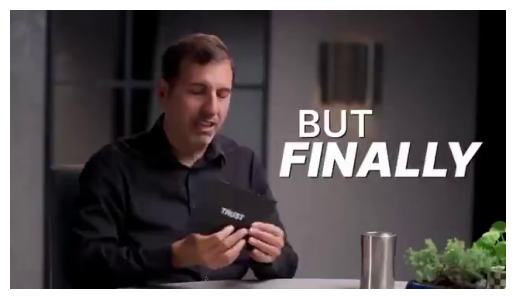

read frame 2


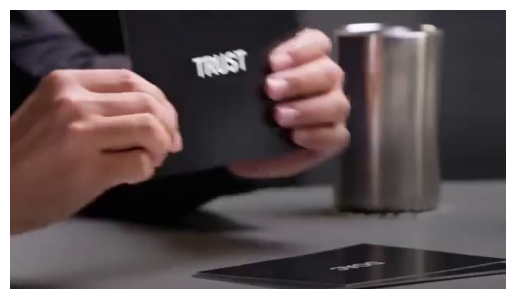

read frame 4


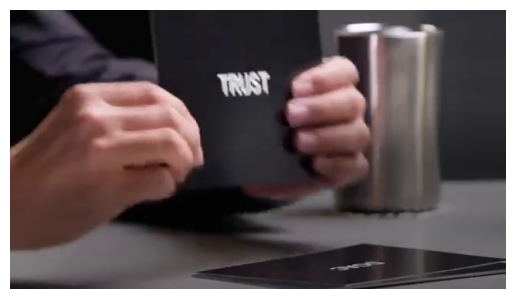

read frame 6


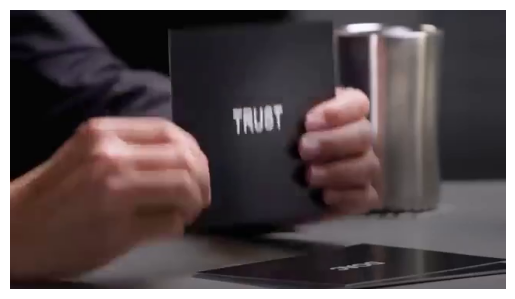

read frame 8


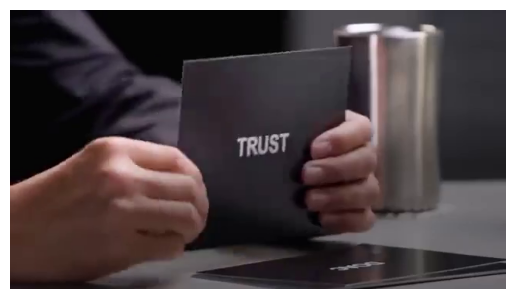

read frame 10


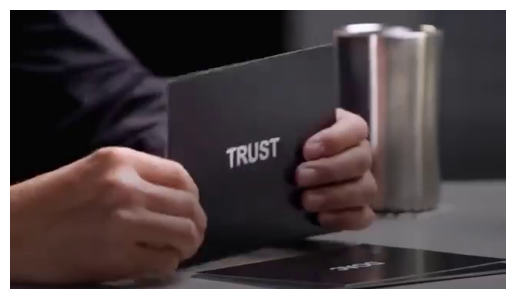

read frame 12


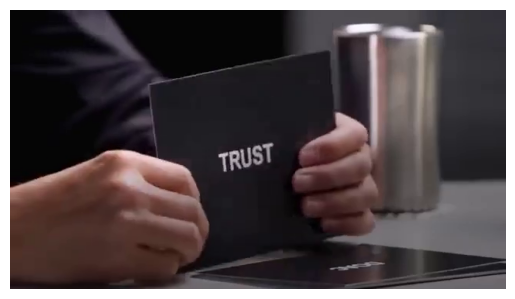

read frame 14


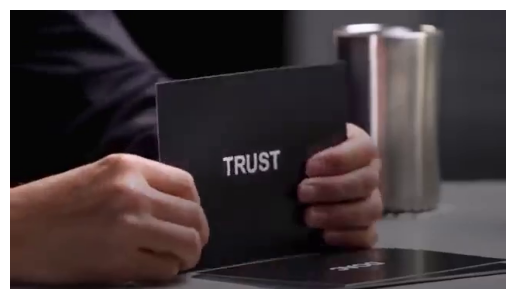

 The image shows a still from a video, possibly a television show or film clip. It features a man sitting at a table with what appears to be a smartphone in front of him. He is dressed in a dark shirt and has his attention focused on the screen of the device. The man has short hair and is looking down at the phone's screen, which is displaying some content.

Above the image, there are two pieces of text overlaid on it: "BUT FINALLY" in a bold white font, and "I WILL NEVER DO THIS AGAIN" in smaller black font. The background behind the man suggests an indoor setting with a contemporary design, featuring dark colors and modern furniture.

The style of the image is realistic and appears to be a candid moment captured from the television screen. The text overlay indicates that this scene is part of a narrative where the character has completed or ended a task or activity for the last time. 
 In the image, there is a scene featuring two individuals. On the left side of the frame, one person

FileExistsError: [Errno 17] File exists: '/home/tyler/python/agents/cut_descriptions/sunlight-Scene-040'

In [90]:
for cut in os.listdir(CUTS_PATH):
    frame_descriptions = []

    frame_buffers = get_frames(cut)
    for frame_buffer in frame_buffers:
        frame_description = describe_image(frame_buffer)
        print(frame_description)
        frame_descriptions.append(frame_description)
        write_frame_descriptions(cut, frame_description)

    break